# 네이버 영화평(1,000페이지) 수집기

In [ ]:
import requests

userAgent = {"user-agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36"}
getDownload = lambda url: requests.get(url, headers=userAgent)

In [ ]:
import re

getCleanText = lambda item: re.sub(r"[\s]{2,}", " ", item.strip().replace(",", " "))

In [ ]:
from bs4 import BeautifulSoup

url = "https://movie.naver.com/movie/point/af/list.nhn?&page="

pageNo = 1
maxPageNo = 1001
lastReviewNo = 0

saveFilePath = "./파일이름.txt"

fp = open(saveFilePath, "w", encoding="utf-8")
fp.close()

html = getDownload(url+str(pageNo))

while html.status_code == 200 and pageNo < maxPageNo:
    dom = BeautifulSoup(html.text, "html.parser")
    pointList = dom.select(".list_netizen tbody > tr")
    
    fp = open(saveFilePath, "a", encoding="utf-8")
    
    for pointInfo in pointList:
        pointItem = [point for point in pointInfo.select("td")]
        pointID = getCleanText(pointItem[0].text)
        pointScore = getCleanText(pointItem[2].text)
        pointMovie = getCleanText(pointItem[3].select_one("a").text)
        pointComment = getCleanText(pointItem[3].contents[3].contents[0])
        pointRegData = getCleanText(pointItem[4].contents[-1].text)
        
        if lastReviewNo == pointID:
            continue
        else:
            fp.write("{0},{1},{2},{3},{4}\n".format(pointID, pointScore, pointMovie, pointComment, pointRegData))
        
    fp.close()
    
    lastReviewNo = pointID
        
    pageNo += 1
    html = getDownload(url+str(pageNo))

    if pageNo % 100 == 0:
        print("{0} pages were crawled.".format(pageNo))

# 데이터 가져오기(Pandas) 및 전처리

In [1]:
import pandas as pd

reviews = pd.read_csv("./0622.txt", header=None, names=["no", "score", "movie", "review", "regdate"])
reviews = reviews[reviews["review"].notnull()]
reviews = reviews.drop_duplicates()

In [2]:
from konlpy.tag import Komoran

ma = Komoran()
documents = list()

for review in reviews["review"]:
    documents.append([pos[0] for pos in ma.pos(review) if len(pos[0]) > 1 and pos[1] in ["NNG", "NNP"]])

# 토픽 모델링(LDA-클러스터링)

In [91]:
from random import randrange

a = 0.1
b = 0.1
K = 5

docTermTopicMat = list()
Vocabulary = list()

for doc in documents:
    termTopic = list()
    
    for term in doc:
        termTopic.append([term, randrange(K)])
        Vocabulary.append(term)
        
    docTermTopicMat.append(termTopic)
    
Vocabulary = list(set(Vocabulary))

M = len(docTermTopicMat)
N = len(Vocabulary)

In [61]:
from collections import defaultdict

topicTermMatrix = defaultdict(lambda:defaultdict(int))
docTopicMatrix = defaultdict(lambda:defaultdict(int))
topicCount = defaultdict(int)

for i, termTopic in enumerate(docTermTopicMat):
    for row in termTopic:
        topicTermMatrix[row[1]][row[0]] += 1
        docTopicMatrix[i][row[1]] += 1
        topicCount[row[1]] += 1

In [62]:
from random import random, choices

def topicLikelihood(k, l):
    return (topicTermMatrix[k][l] + b) / (topicCount[k] + (b*N))#(sum(topicTermMatrix[k].values()) + (b*N))

def docLikelihood(m, k):
    return (docTopicMatrix[m][k] + a)

def topicAssign(m, l):
    probList = list()
    for k in range(K):
        probList.append(topicLikelihood(k, l) * docLikelihood(m, k))

    return choices(range(K), probList, k=1)[0]
#     _sum = sum(probList) * random()
#     for i, p in enumerate(probList):
#         _sum -= p
#         if _sum <= 0:
#             k = i
#             break
#     return k

In [63]:
from tqdm import tqdm

_iter = 1000

for _ in tqdm(range(_iter)):
    for i, termTopic in enumerate(docTermTopicMat):
        for row in termTopic:
            topicTermMatrix[row[1]][row[0]] -= 1
            docTopicMatrix[i][row[1]] -= 1
            topicCount[row[1]] -= 1
            
            k = topicAssign(i, row[0])
            
            row[1] = k
            topicTermMatrix[row[1]][row[0]] += 1
            docTopicMatrix[i][row[1]] += 1
            topicCount[row[1]] += 1

100%|██████████| 1000/1000 [04:16<00:00,  3.92it/s]


1번째 토픽 => 알라딘
['영화', '최고', '감동', '노래', '시간', '!!', '알라딘', '생각', '스미스', '인생']


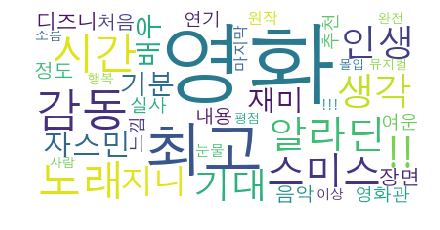

2번째 토픽 => 토이스토리
['스토리', '토이', '우디', '감동', '영화', '시리즈', '기대', '눈물', '마지막', '최고']


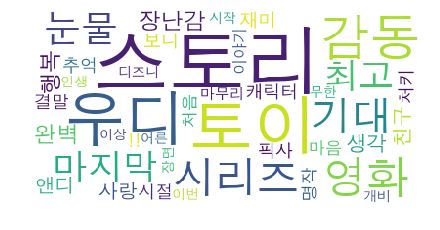

3번째 토픽 => 공포
['영화', '평점', '알바', '사람', '한국', '공포', '댓글', '기대', '생각', '스토리']


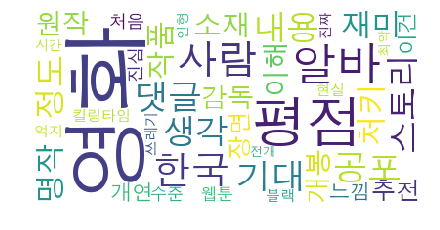

4번째 토픽 => 드라마
['영화', '생각', '사람', '마음', '감독', '현실', '봉준호', '가슴', '인간', '이야기']


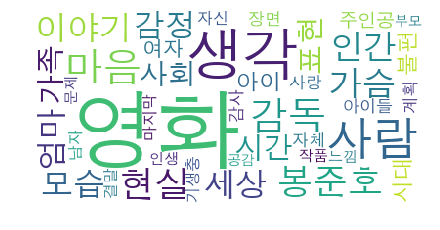

5번째 토픽 => 액션
['김래원', '영화', '연기', '배우', '!!', '중간', '재미', '범죄도시', '기대', '감독']


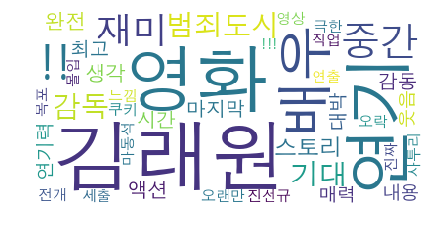

In [85]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(font_path="/Libray/Fonts/AppleGothic.ttf", background_color="white")

for k, name in zip(sorted(topicTermMatrix.keys()), ["알라딘", "토이스토리", "공포", "드라마", "액션"]):
    print(str(k+1)+"번째 토픽 =>", name)
    print([term for term, freq in sorted(topicTermMatrix[k].items(), key=lambda x:x[1], reverse=True)[:10]])
    wc.generate_from_frequencies({term:freq for term, freq in sorted(topicTermMatrix[k].items(), key=lambda x:x[1], reverse=True)[:40]})
    plt.imshow(wc.to_array())
    plt.rcParams["figure.figsize"] = (7,5)
    plt.axis("off")
    plt.show()

# 감성분석(어휘기반-NPMI)

In [87]:
TDM = defaultdict(lambda: defaultdict(int))

for docName, termList in enumerate(documents):
    for term in termList:
        TDM[term][docName] += 1

In [92]:
from math import log

pSeeds = ["감동", "최고", "행복"]
nSeeds = ["쓰레기", "억지", "최악"]

N = len(documents)
smoothing = 0.1

positivePMI = defaultdict(lambda: defaultdict(float))
positiveNPMI = defaultdict(lambda: defaultdict(float))

negativePMI = defaultdict(lambda: defaultdict(float))
negativeNPMI = defaultdict(lambda: defaultdict(float))

for seed in pSeeds:
    seedDocList = set(list(TDM[seed].keys()))
    seedLikelihood = len(seedDocList)/N

    for term in Vocabulary:
        termDocList = list(TDM[term].keys())
        termLikelihood = len(termDocList)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + smoothing)/N
        multiLikelihood = seedLikelihood * termLikelihood

        positivePMI[term][seed] = log(jointLikelihood/multiLikelihood)
        positiveNPMI[term][seed] = positivePMI[term][seed]/-log(jointLikelihood)
        

for seed in nSeeds:
    seedDocList = set(list(TDM[seed].keys()))
    seedLikelihood = len(seedDocList)/N

    for term in Vocabulary:
        termDocList = list(TDM[term].keys())
        termLikelihood = len(termDocList)/N

        jointLikelihood = (len(seedDocList.intersection(termDocList)) + smoothing)/N
        multiLikelihood = seedLikelihood * termLikelihood

        negativePMI[term][seed] = log(jointLikelihood/multiLikelihood)
        negativeNPMI[term][seed] = negativePMI[term][seed]/-log(jointLikelihood)

In [94]:
pmiSO = defaultdict(float)
npmiSO = defaultdict(float)

for term in Vocabulary:
    positivePmiSum = 0.0
    positiveNpmiSum = 0.0
    
    negativePmiSum = 0.0
    negativeNpmiSum = 0.0    
    
    for seed in pSeeds:
        positivePmiSum += positivePMI[term][seed]
        positiveNpmiSum += positiveNPMI[term][seed]
        
    for seed in nSeeds:
        negativePmiSum += negativePMI[term][seed]
        negativeNpmiSum += negativeNPMI[term][seed]
        
    pmiSO[term] = positivePmiSum - negativePmiSum
    npmiSO[term] = positiveNpmiSum - negativeNpmiSum

In [95]:
positivePmiList = dict(sorted(pmiSO.items(), key=lambda x:x[1], reverse=True)[:30])
negativePmiList = dict(sorted(pmiSO.items(), key=lambda x:x[1], reverse=False)[:30])

positiveNpmiList = dict(sorted(npmiSO.items(), key=lambda x:x[1], reverse=True)[:30])
negativeNpmiList = dict(sorted(npmiSO.items(), key=lambda x:x[1], reverse=False)[:30])

긍정-PMI
['토이', '알라딘', '노래', '행복', '완벽', '친구', '자스민', '최고', '감동', '보니', '눈물', '실사', '픽사', '감사', '우디', '명작', '스미스', '!!', '가슴', '음악', '대박', '배우', '교훈', '아이', '애니메이션', '어른', '버즈', '웃음', '이번', '무한']


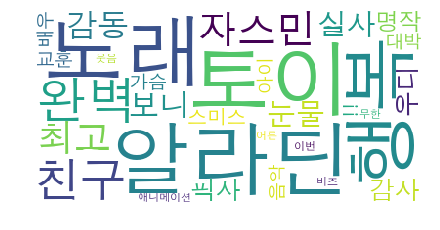

부정-PMI
['더보', '아픔', '여주', '어이', '빨갱이', '집사람', '귀신', '개똥', '등급', '각색', '다음', '개연', '저급', '양아치', '설득력', '이하', '연관', '시계', '보지', '경찰', '악의', '품격', '성제', '플롯', '영상물', '우연', '네이버', '최악', '쓰레기', '수준']


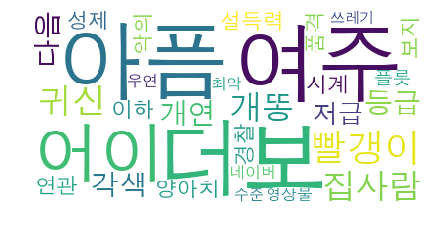

긍정-NPMI
['최고', '감동', '행복', '토이', '알라딘', '노래', '우디', '완벽', '친구', '자스민', '실사', '눈물', '보니', '픽사', '감사', '교훈', '웃음', '명작', '스미스', '버즈', '무한', '!!', '애니메이션', '공간', '음악', '가슴', '너머', '시절', '이번', '대박']


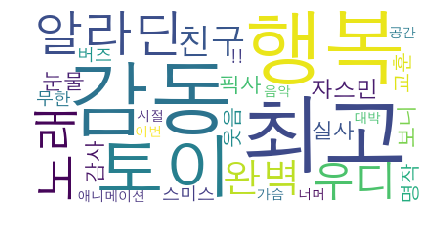

부정-NPMI
['고질병', '관련', '해도', '감독', '등급', '귀신', '한마디', '다음', '개똥', '각색', '보지', '경찰', '이하', '플롯', '개연', '시계', '설득력', '우연', '악의', '연관', '저급', '양아치', '억지', '영상물', '네이버', '성제', '품격', '수준', '쓰레기', '최악']


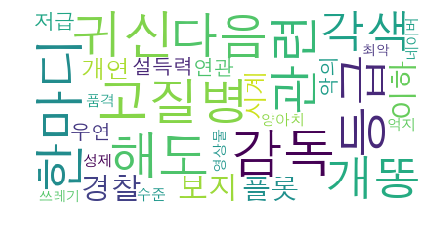

In [99]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(font_path="/Libray/Fonts/AppleGothic.ttf", background_color="white")

for termList, name in zip([positivePmiList, negativePmiList, positiveNpmiList, negativeNpmiList], ["긍정-PMI", "부정-PMI", "긍정-NPMI", "부정-NPMI"]):
    print(name)
    print([term[0] for term in sorted(termList.items(), key=lambda x:x[1], reverse=True)])
    wc.generate_from_frequencies(termList)
    plt.imshow(wc.to_array())
    plt.rcParams["figure.figsize"] = (7,5)
    plt.axis("off")
    plt.show()

 Topic       PMI       NPMI 
ㅇㅇ알라딘   +81.4191  +10.2407
토이스토리  +109.0351  +14.0163
ㅇㅇㅇ공포  -122.3631  -14.7388
ㅇㅇ드라마    +0.2166   -0.2165
ㅇㅇㅇ액션    -3.7909   +0.8416


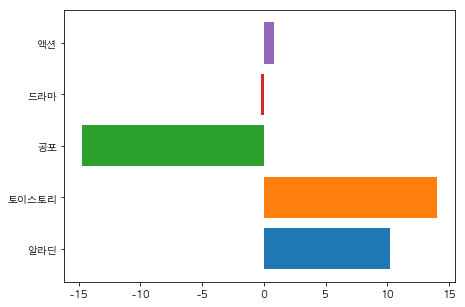

In [164]:
from matplotlib import font_manager

font = font_manager.FontProperties(fname="/Library/Fonts/AppleGothic.ttf").get_name()
plt.rcParams["font.family"] = font
plt.rcParams['axes.unicode_minus'] = False

print("{0:^8s} {1:^12s} {2:^6}".format("Topic", "PMI", "NPMI"))

for topic, title in zip(sorted(topicTermMatrix.keys()), ["알라딘", "토이스토리", "공포", "드라마", "액션"]):
    sentimentPMI = 0.0
    sentimentNPMI = 0.0
    
    topicWords = sorted(topicTermMatrix[topic].items(), key=lambda x:x[1], reverse=True)[:40]
    
    for term in topicWords:
        sentimentPMI += pmiSO[term[0]]
        sentimentNPMI += npmiSO[term[0]]
        
    print("{0:ㅇ>5s} {1:>+10.4f} {2:>+9.4f}".format(title, sentimentPMI, sentimentNPMI))
    plt.barh(title, sentimentNPMI)
plt.show()